# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)
    
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/robertmartin8/PyPortfolioOpt/blob/master/cookbook/4-Black-Litterman-Allocation.ipynb)

In [1]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

Cloning into 'PyPortfolioOpt'...


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta

In [3]:
tickers = ['ZOMATO.NS','BHARTIARTL.NS','PAYTM.NS','SWIGGY.NS','NYKAA.NS']

In [4]:
end_date = datetime.today()
start_date=end_date-timedelta(days=2*365)

In [5]:
ohlc = yf.download(tickers,start=start_date,end=end_date)
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  5 of 5 completed


Ticker,BHARTIARTL.NS,NYKAA.NS,PAYTM.NS,SWIGGY.NS,ZOMATO.NS
Date,,,,,
2025-01-01 00:00:00+00:00,1595.699951,164.679993,987.599976,542.349976,276.500000
2025-01-02 00:00:00+00:00,1609.699951,165.320007,982.400024,556.450012,284.600006
2025-01-03 00:00:00+00:00,1598.849976,167.839996,982.799988,541.450012,272.850006
2025-01-06 00:00:00+00:00,1588.449951,171.520004,969.049988,532.099976,264.850006
2025-01-07 00:00:00+00:00,1590.849976,172.309998,983.200012,509.250000,252.449997


In [6]:
market_prices = yf.download("^NSEI",start=start_date,end=end_date)["Adj Close"]
market_prices.tail()

[*********************100%***********************]  1 of 1 completed


Date
2025-01-01    23742.900391
2025-01-02    24188.650391
2025-01-03    24004.750000
2025-01-06    23616.050781
2025-01-07    23707.900391
Name: Adj Close, dtype: float64

In [7]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'ZOMATO.NS': 2288449224704,
 'BHARTIARTL.NS': 9515970854912,
 'PAYTM.NS': 626674958336,
 'SWIGGY.NS': 1139930562560,
 'NYKAA.NS': 492834160640}

## Constructing the prior

In [8]:
import pypfopt
pypfopt.__version__

(CVXPY) Jan 08 08:25:20 AM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/opt/anaconda3/lib/python3.12/site-packages/cvxopt/base.cpython-312-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <42996129-43CF-3CE3-AEAF-6CE0B43F76A9> /opt/anaconda3/lib/python3.12/site-packages/cvxopt/base.cpython-312-darwin.so\n  Reason: tried: '/opt/anaconda3/lib/python3.12/site-packages/cvxopt/../../../liblapack.3.dylib' (no such file), '/opt/anaconda3/lib/python3.12/site-packages/cvxopt/../../../liblapack.3.dylib' (no such file), '/opt/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")
(CVXPY) Jan 08 08:25:20 AM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/opt/anaconda3/lib/python3.12/site-packages/cvxopt/base.cpython-312-da

'1.5.6'

In [9]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

9.823076242177637

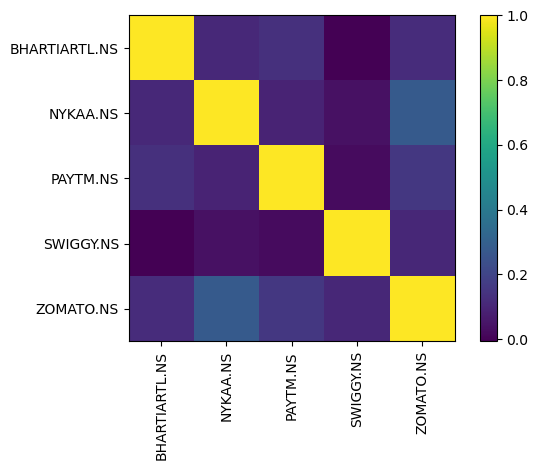

In [10]:
plotting.plot_covariance(S, plot_correlation=True);

In [11]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
BHARTIARTL.NS    0.328838
NYKAA.NS         0.167891
PAYTM.NS         0.294430
SWIGGY.NS        0.037377
ZOMATO.NS        0.339929
dtype: float64

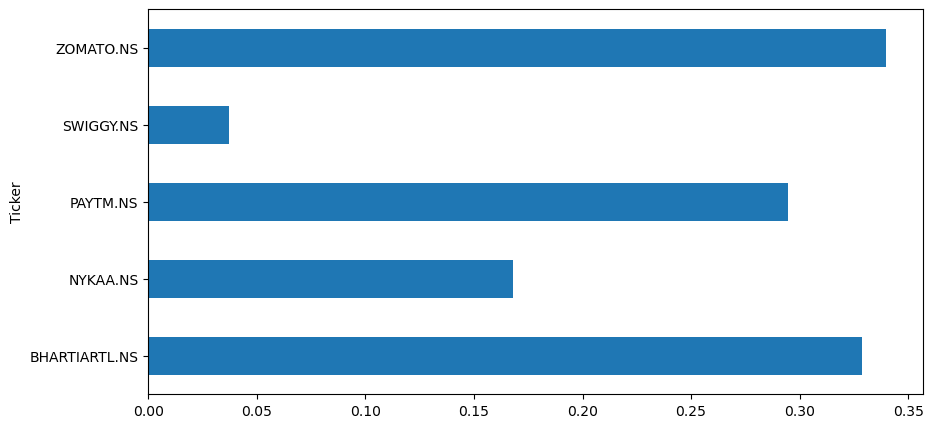

In [12]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [13]:
# You don't have to provide views on all the assets
viewdict = {
    "ZOMATO.NS": -.10,
    "BHARTIARTL.NS": 0.15,
    "PAYTM.NS": 0.05,
    "SWIGGY.NS": -0.05,
    "NYKAA.NS": -0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [14]:
confidences = [
    .6,
    .5,
    .2,
    .5,
    .3]

In [15]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

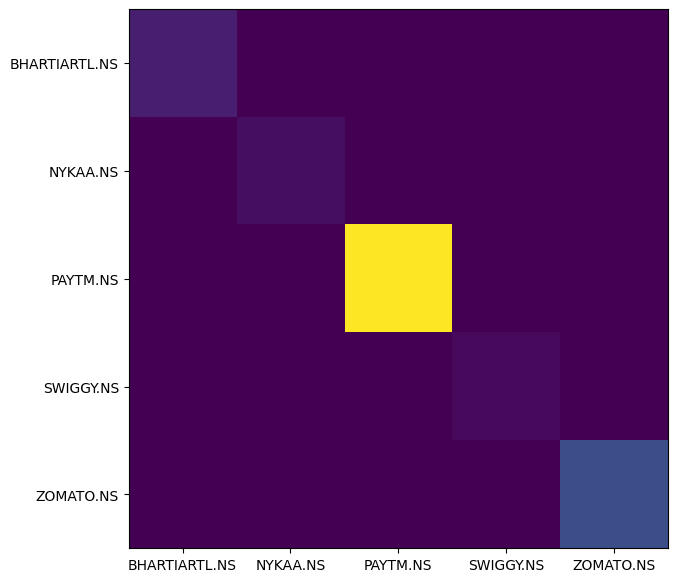

In [16]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [17]:
np.diag(bl.omega)

array([0.00499616, 0.00228245, 0.06021115, 0.00160435, 0.01453094])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [18]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25)]

In [19]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [20]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [21]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
BHARTIARTL.NS    0.291148
NYKAA.NS        -0.034750
PAYTM.NS         0.145920
SWIGGY.NS        0.010505
ZOMATO.NS        0.152078
dtype: float64

We can visualise how this compares to the prior and our views:

In [22]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BHARTIARTL.NS,0.328838,0.291148,0.15
NYKAA.NS,0.167891,-0.034750,-0.10
PAYTM.NS,0.294430,0.145920,0.05
SWIGGY.NS,0.037377,0.010505,-0.05
ZOMATO.NS,0.339929,0.152078,-0.10


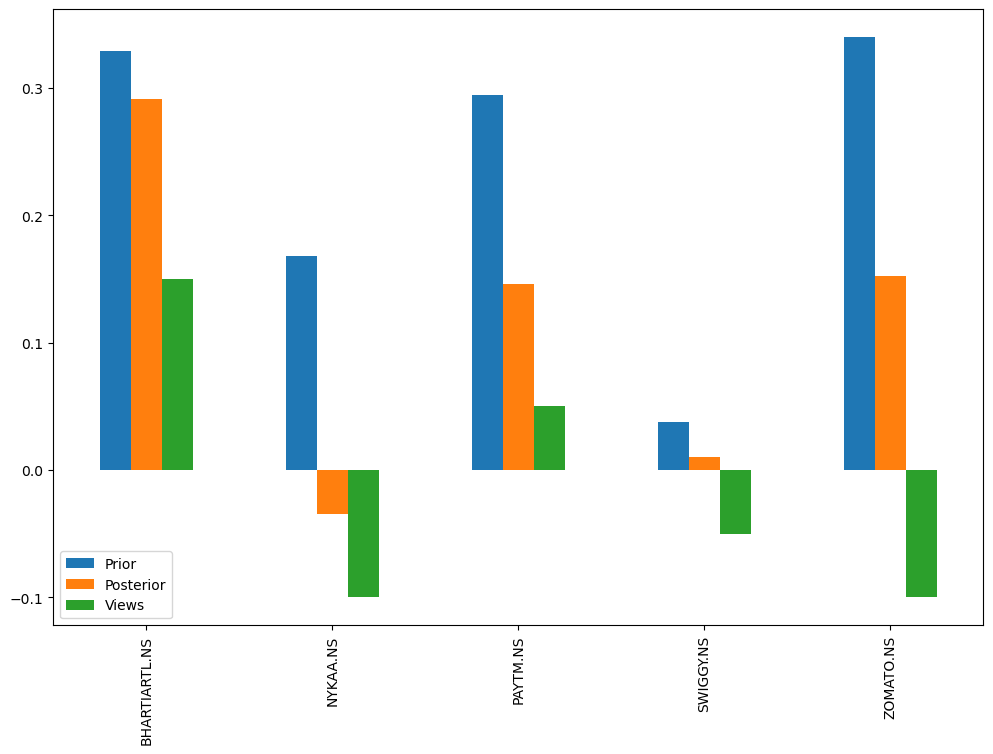

In [23]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

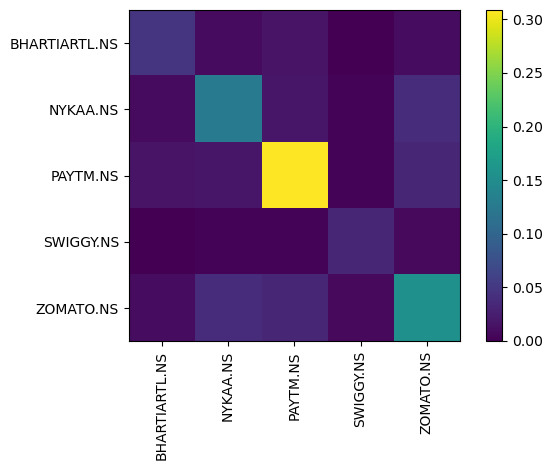

In [24]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [25]:
from pypfopt import EfficientFrontier, objective_functions

In [26]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/opt/anaconda3/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('BHARTIARTL.NS', 0.53383),
             ('NYKAA.NS', 0.0),
             ('PAYTM.NS', 0.2037),
             ('SWIGGY.NS', 0.01765),
             ('ZOMATO.NS', 0.24481)])

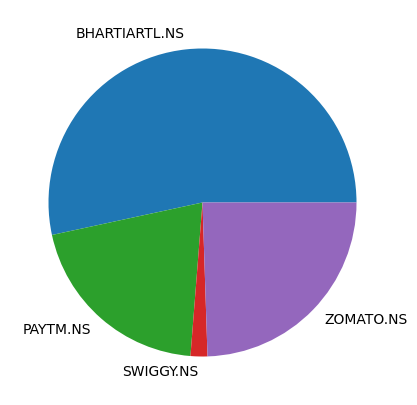

In [27]:
pd.Series(weights).plot.pie(figsize=(12,5));

In [28]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=8000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ₹{leftover:.2f}")
alloc

Leftover: ₹52.34


{'BHARTIARTL.NS': 3, 'NYKAA.NS': 1, 'PAYTM.NS': 1, 'ZOMATO.NS': 8}

In [29]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=8000)
alloc, leftover = da.greedy_portfolio()
print(f"Leftover: ₹{leftover:.2f}")
alloc

Leftover: ₹323.05


{'BHARTIARTL.NS': 2, 'ZOMATO.NS': 8, 'PAYTM.NS': 2, 'SWIGGY.NS': 1}